In [65]:
import tensorflow as tf 
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt 
import skimage.transform as skTrans

In [66]:
trainedModelPath = ".\\trained_model\\"
rootDirPath = "..\\mmwhs\\ct_train\\"

In [67]:
unetAxial = tf.keras.models.load_model(os.path.join(trainedModelPath, "unetAxial.h5"))
unetAxial.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [73]:
def ConvertPredictToImage(sliceImagePredict):
    def MapArgmax(x):
        encodeList = {
            0: 0,
            1: 500,
            2: 600,
            3: 420,
            4: 550,
            5: 205,
            6: 820,
            7: 850,
        }
        return encodeList.get(x, None)

    a = sliceImagePredict.copy()
    a = a.argmax(axis=-1)
    a = np.vectorize(MapArgmax)(a)
    return a

In [74]:
x = np.load("./x_axial.npy")
y = np.load("./y_axial.npy")

In [105]:
sliceImage = np.squeeze(x[300], axis=-1)
sliceLabel = ConvertPredictToImage(y[300])

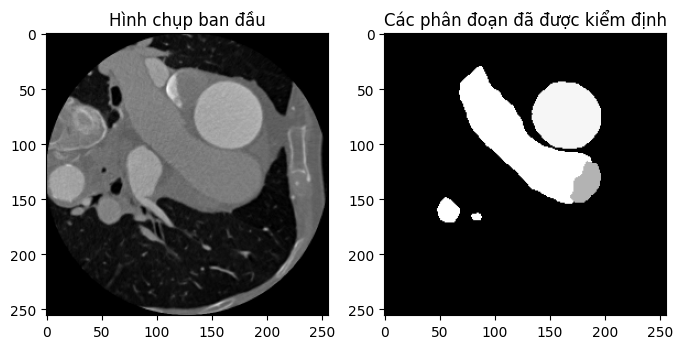

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(8, 6))
axes[0].set_title("Hình chụp ban đầu")
axes[0].imshow(sliceImage, cmap="gray")
axes[1].set_title("Các phân đoạn đã được kiểm định")
axes[1].imshow(sliceLabel, cmap="gray")

In [107]:
sliceImageForPredict = [sliceImage]
sliceImageForPredict = np.expand_dims(sliceImageForPredict, -1)
print(sliceImageForPredict.shape)

(1, 256, 256, 1)


In [109]:
sliceImagePredict = unetAxial.predict(sliceImageForPredict)
sliceImagePredict = sliceImagePredict[0]

1/1 [==============================] - 0s 71ms/step


In [110]:
sliceImagePredict = ConvertPredictToImage(sliceImagePredict)

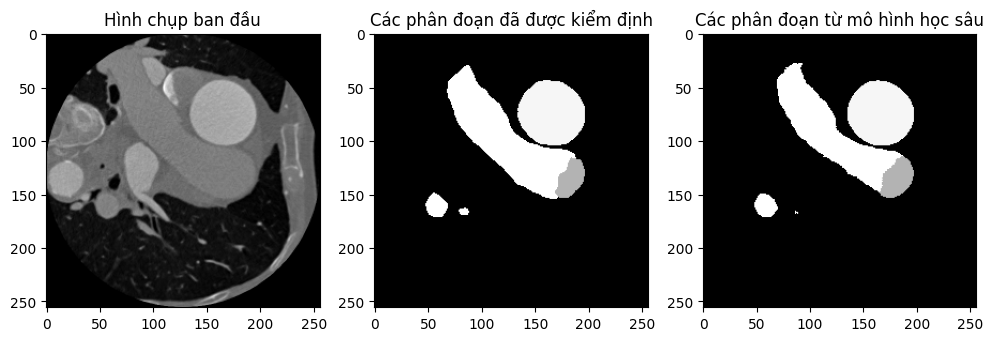

In [111]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].set_title("Hình chụp ban đầu")
axes[0].imshow(sliceImage, cmap="gray")
axes[1].set_title("Các phân đoạn đã được kiểm định")
axes[1].imshow(sliceLabel, cmap="gray")
axes[2].set_title("Các phân đoạn từ mô hình học sâu")
axes[2].imshow(sliceImagePredict, cmap="gray")

In [112]:
print(f"Unique label: {np.unique(sliceLabel)}, Unique predict value: {np.unique(sliceImagePredict)}")

Unique label: [  0 600 820 850], Unique predict value: [  0 600 820 850]


In [ ]:
def DiceCoefficient(y_true, y_pred, class_id):
    # Create binary masks for the specific class
    y_true_class = np.where(y_true == class_id, 1, 0)
    y_pred_class = np.where(y_pred == class_id, 1, 0)

    # Calculate the intersection between the masks
    intersection = np.logical_and(y_true_class, y_pred_class).sum()

    # Calculate the sum of elements in each mask
    sum_y_true = np.sum(y_true_class)
    sum_y_pred = np.sum(y_pred_class)

    # Calculate the Dice coefficient for the class
    # Adding a small epsilon to avoid division by zero
    dice = (2.0 * intersection) / (sum_y_true + sum_y_pred + 1e-8)

    return dice


def DiceMultiClass(y_true, y_pred, num_classes):
    dice_scores = []
    for class_id in range(num_classes):
        dice = DiceCoefficient(y_true, y_pred, class_id)
        dice_scores.append(dice)

    # Calculate the average Dice coefficient across all classes
    average_dice = np.mean(dice_scores)
    return average_dice